### 单纯重建URDF

In [1]:
import h5py
import numpy as np
import k3d
import trimesh
import os
from omegaconf import OmegaConf
from airexo.helpers.urdf_robot import forward_kinematic
from airexo.helpers.constants import ROBOT_PREDEFINED_TRANSFORMATION

# 1. 读取关节数据
scene_path = "/data/haoxiang/data/airexo2/task_0013/train/scene_0001/lowdim"

with h5py.File(f"{scene_path}/robot_left.h5", 'r') as f:
    left_joint = f['joint_pos'][0]  # 第一帧，shape=(7,)

with h5py.File(f"{scene_path}/robot_right.h5", 'r') as f:
    right_joint = f['joint_pos'][0]

with h5py.File(f"{scene_path}/gripper_left.h5", 'r') as f:
    left_gripper = f['width'][0] if 'width' in f else 0.05

with h5py.File(f"{scene_path}/gripper_right.h5", 'r') as f:
    right_gripper = f['width'][0] if 'width' in f else 0.05

# 拼接关节+夹爪
left_joint = np.concatenate([left_joint, [left_gripper]])
right_joint = np.concatenate([right_joint, [right_gripper]])

# 2. 加载 joint_cfgs
left_cfg = OmegaConf.load("airexo/configs/joint/left/robot.yaml")
right_cfg = OmegaConf.load("airexo/configs/joint/right/robot.yaml")

# 3. 前向运动学
cur_transforms, visuals_map = forward_kinematic(
    left_joint=left_joint,
    right_joint=right_joint,
    left_joint_cfgs=left_cfg,
    right_joint_cfgs=right_cfg,
    is_rad=True, 
    urdf_file="airexo/urdf_models/robot/robot_inhand.urdf",
    with_visuals_map=True
)

# 4. 加载并变换 mesh
plot = k3d.plot()
for link, transform in cur_transforms.items():
    if link not in visuals_map: continue
    
    for v in visuals_map[link]:
        if v.geom_param is None: continue
        
        # 构建完整路径
        mesh_path = os.path.join("airexo/urdf_models/robot", v.geom_param)
        
        if not os.path.exists(mesh_path):
            print(f"Warning: Mesh file not found: {mesh_path}")
            continue

        # 使用 force='mesh' 确保加载进来的是 Trimesh 对象而不是 Scene
        mesh = trimesh.load(mesh_path, force='mesh')
        
        # 应用变换矩阵
        tf = ROBOT_PREDEFINED_TRANSFORMATION @ transform.matrix() @ v.offset.matrix()
        mesh.apply_transform(tf)
        
        # 渲染到 k3d
        plot += k3d.mesh(mesh.vertices.astype(np.float32), 
                         mesh.faces.astype(np.uint32),
                         color=0xd3d3d3) # 浅灰色

plot.display()

/home/haoxiang/miniforge3/envs/airexo/lib/python3.8/site-packages/traittypes/traittypes.py:98: UserWarning: Given trait value dtype "float32" does not match required type "float32". A coerced copy has been created.
  warnings.warn(
/home/haoxiang/miniforge3/envs/airexo/lib/python3.8/site-packages/traittypes/traittypes.py:98: UserWarning: Given trait value dtype "uint32" does not match required type "uint32". A coerced copy has been created.
  warnings.warn(


Output()

#### claude手搓的逻辑（对不齐）

In [ ]:
import h5py
import numpy as np
import k3d
import trimesh
import os
from omegaconf import OmegaConf
from airexo.helpers.urdf_robot import forward_kinematic
from airexo.helpers.constants import ROBOT_PREDEFINED_TRANSFORMATION,O3D_RENDER_TRANSFORMATION
from airexo.calibration.calib_info import CalibrationInfo
import open3d as o3d

# ========== 1. 读取关节数据 ==========
scene_path = "/data/haoxiang/data/airexo2/task_0013/train/scene_0001"
lowdim_path = os.path.join(scene_path, "lowdim")

with h5py.File(f"{lowdim_path}/robot_left.h5", 'r') as f:
    left_joint = f['joint_pos'][0]

with h5py.File(f"{lowdim_path}/robot_right.h5", 'r') as f:
    right_joint = f['joint_pos'][0]

with h5py.File(f"{lowdim_path}/gripper_left.h5", 'r') as f:
    left_gripper = f['width'][0] if 'width' in f else 0.05

with h5py.File(f"{lowdim_path}/gripper_right.h5", 'r') as f:
    right_gripper = f['width'][0] if 'width' in f else 0.05

left_joint = np.concatenate([left_joint, [left_gripper]])
right_joint = np.concatenate([right_joint, [right_gripper]])

# ========== 2. 加载标定数据 ==========
calib_path = "/data/haoxiang/data/airexo2/task_0013/calib"
calib_info = CalibrationInfo(
    calib_path=calib_path,
    calib_timestamp=1737548651048  # 自动找最新的标定文件
)

# 获取相机序列号
camera_serial = list(calib_info.camera_serials_global)[0]
print(f"Using camera: {camera_serial}")

# 获取相机到机器人基座的变换和内参
cam_to_base = calib_info.get_camera_to_base(camera_serial)
intrinsic = calib_info.get_intrinsic(camera_serial)

# ========== 3. 前向运动学（重建机械臂） ==========
left_cfg = OmegaConf.load("airexo/configs/joint/left/robot.yaml")
right_cfg = OmegaConf.load("airexo/configs/joint/right/robot.yaml")

cur_transforms, visuals_map = forward_kinematic(
    left_joint=left_joint,
    right_joint=right_joint,
    left_joint_cfgs=left_cfg,
    right_joint_cfgs=right_cfg,
    is_rad=True,
    urdf_file="airexo/urdf_models/robot/robot_inhand.urdf",  # 包含中间框架
    with_visuals_map=True
)

# ========== 4. 读取深度图并转换为点云 ==========
cam_path = os.path.join(scene_path, f"cam_{camera_serial}")
print(f"Reading depth and RGB from: {cam_path}")
depth_path = os.path.join(cam_path, "depth", "1737546126606.png")  # 第一帧
rgb_path = os.path.join(cam_path, "color", "1737546126606.png")

# 读取深度和RGB
depth_img = o3d.io.read_image(depth_path)
rgb_img = o3d.io.read_image(rgb_path)

# 创建 RGBD 图像
rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
    rgb_img, depth_img,
    depth_scale=1000.0,  # 深度单位转米
    convert_rgb_to_intensity=False
)

print(f"Intrinsic type: {type(intrinsic)}")
print(f"Intrinsic content:\n{intrinsic}")

# 转换为点云（相机坐标系）

# 1. 从矩阵中提取 4 个核心参数
fx = intrinsic[0, 0]
fy = intrinsic[1, 1]
cx = intrinsic[0, 2]
cy = intrinsic[1, 2]

# 2. 从 rgb_img 获取分辨率
# 如果 rgb_img 是 Open3D 对象，可以用 np.asarray(rgb_img).shape
h, w = np.asarray(rgb_img).shape[:2] 

# 3. 构造 Open3D 的内参对象
intrinsic_o3d = o3d.camera.PinholeCameraIntrinsic(
    width=int(w),
    height=int(h),
    fx=float(fx),
    fy=float(fy),
    cx=float(cx),
    cy=float(cy)
)

# 4. 转换为点云
pcd_cam = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd,
    intrinsic_o3d
)

# 变换到机器人基座坐标系
pcd_cam.transform(cam_to_base)

# ========== 5. K3D 可视化 ==========
plot = k3d.plot()

# 5.1 渲染机械臂（包括中间框架）
for link, transform in cur_transforms.items():
    if link not in visuals_map: continue
    
    for v in visuals_map[link]:
        if v.geom_param is None: continue
        
        mesh_path = os.path.join("airexo/urdf_models/robot", v.geom_param)
        if not os.path.exists(mesh_path):
            continue

        mesh = trimesh.load(mesh_path, force='mesh')
        tf = ROBOT_PREDEFINED_TRANSFORMATION @ transform.matrix() @ v.offset.matrix()
        mesh.apply_transform(tf)

        
        # 机械臂用灰色
        plot += k3d.mesh(mesh.vertices.astype(np.float32), 
                         mesh.faces.astype(np.uint32),
                         color=0xaaaaaa)

# 5.2 渲染点云
pcd_points = np.asarray(pcd_cam.points).astype(np.float32)

# ✅ 点云也要应用 ROBOT_PREDEFINED_TRANSFORMATION 才能和机械臂对齐
pcd_points_transformed = (ROBOT_PREDEFINED_TRANSFORMATION[:3, :3] @ pcd_points.T + 
                          ROBOT_PREDEFINED_TRANSFORMATION[:3, 3:4]).T


pcd_colors = np.asarray(pcd_cam.colors).astype(np.float32)

# 1. 先映射到 0-255，然后务必转换为 uint32
pcd_colors_uint32 = (pcd_colors * 255).astype(np.uint32)

# 2. 进行位移操作 (R << 16 | G << 8 | B)
pcd_colors_packed = (pcd_colors_uint32[:, 0] << 16) | \
                    (pcd_colors_uint32[:, 1] << 8) | \
                     pcd_colors_uint32[:, 2]

plot += k3d.points(pcd_points, 
                   colors=pcd_colors_packed,
                   point_size=0.002,
                   shader='flat')

# 5.3 添加坐标轴（机器人基座）
axis_size = 0.3
axes = k3d.vectors(
    origins=[[0, 0, 0], [0, 0, 0], [0, 0, 0]],
    vectors=[[axis_size, 0, 0], [0, axis_size, 0], [0, 0, axis_size]],
    colors=[0xff0000, 0x00ff00, 0x0000ff],  # RGB
    line_width=0.01
)
plot += axes

plot.display()

### 完全照抄原仓库renderer的变换逻辑

In [3]:
import h5py
import numpy as np
import k3d
import trimesh
import os
from omegaconf import OmegaConf
from airexo.helpers.urdf_robot import forward_kinematic
from airexo.helpers.constants import ROBOT_PREDEFINED_TRANSFORMATION, O3D_RENDER_TRANSFORMATION
from airexo.calibration.calib_info import CalibrationInfo
import open3d as o3d

# ========== 1. 读取关节数据 ==========
scene_path = "/data/haoxiang/data/airexo2/task_0013/train/scene_0001"
lowdim_path = os.path.join(scene_path, "lowdim")

with h5py.File(f"{lowdim_path}/robot_left.h5", 'r') as f:
    left_joint = f['joint_pos'][0]

with h5py.File(f"{lowdim_path}/robot_right.h5", 'r') as f:
    right_joint = f['joint_pos'][0]

with h5py.File(f"{lowdim_path}/gripper_left.h5", 'r') as f:
    left_gripper = f['width'][0] if 'width' in f else 0.05

with h5py.File(f"{lowdim_path}/gripper_right.h5", 'r') as f:
    right_gripper = f['width'][0] if 'width' in f else 0.05

left_joint = np.concatenate([left_joint, [left_gripper]])
right_joint = np.concatenate([right_joint, [right_gripper]])

# ========== 2. 加载标定数据 ==========
calib_path = "/data/haoxiang/data/airexo2/task_0013/calib"
calib_info = CalibrationInfo(
    calib_path=calib_path,
    calib_timestamp=1737548651048
)

camera_serial = list(calib_info.camera_serials_global)[0]
print(f"Using camera: {camera_serial}")

cam_to_base = calib_info.get_camera_to_base(camera_serial)
intrinsic = calib_info.get_intrinsic(camera_serial)

# ========== 3. 前向运动学 ==========
left_cfg = OmegaConf.load("airexo/configs/joint/left/robot.yaml")
right_cfg = OmegaConf.load("airexo/configs/joint/right/robot.yaml")

cur_transforms, visuals_map = forward_kinematic(
    left_joint=left_joint,
    right_joint=right_joint,
    left_joint_cfgs=left_cfg,
    right_joint_cfgs=right_cfg,
    is_rad=True,
    urdf_file="airexo/urdf_models/robot/robot_inhand.urdf",
    with_visuals_map=True
)

# ========== 4. 读取深度图并转换为点云 ==========
cam_path = os.path.join(scene_path, f"cam_{camera_serial}")
depth_path = os.path.join(cam_path, "depth", "1737546126606.png")
rgb_path = os.path.join(cam_path, "color", "1737546126606.png")

depth_img = o3d.io.read_image(depth_path)
rgb_img = o3d.io.read_image(rgb_path)

rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
    rgb_img, depth_img,
    depth_scale=1000.0,
    convert_rgb_to_intensity=False
)

fx = intrinsic[0, 0]
fy = intrinsic[1, 1]
cx = intrinsic[0, 2]
cy = intrinsic[1, 2]
h, w = np.asarray(rgb_img).shape[:2]

intrinsic_o3d = o3d.camera.PinholeCameraIntrinsic(
    width=int(w), height=int(h),
    fx=float(fx), fy=float(fy),
    cx=float(cx), cy=float(cy)
)

pcd_cam = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, intrinsic_o3d)

# ✅ 完全按照 visualizer.py L969
pcd_cam.transform(O3D_RENDER_TRANSFORMATION)

# ========== 5. K3D 可视化 ==========
plot = k3d.plot()

# 5.1 渲染机械臂
# ✅ 完全按照 visualizer.py L990 / renderer.py L241
for link, transform in cur_transforms.items():
    if link not in visuals_map: continue
    
    for v in visuals_map[link]:
        if v.geom_param is None: continue
        
        mesh_path = os.path.join("airexo/urdf_models/robot", v.geom_param)
        if not os.path.exists(mesh_path):
            continue

        mesh = trimesh.load(mesh_path, force='mesh')
        
        # ✅ 完全照抄官方公式
        tf = O3D_RENDER_TRANSFORMATION @ cam_to_base @ ROBOT_PREDEFINED_TRANSFORMATION @ transform.matrix() @ v.offset.matrix()
        mesh.apply_transform(tf)
        
        plot += k3d.mesh(mesh.vertices.astype(np.float32), 
                         mesh.faces.astype(np.uint32),
                         color=0xaaaaaa)

# 5.2 渲染点云
pcd_points = np.asarray(pcd_cam.points).astype(np.float32)
pcd_colors = np.asarray(pcd_cam.colors).astype(np.float32)
pcd_colors_uint32 = (pcd_colors * 255).astype(np.uint32)
pcd_colors_packed = (pcd_colors_uint32[:, 0] << 16) | \
                    (pcd_colors_uint32[:, 1] << 8) | \
                     pcd_colors_uint32[:, 2]

# ✅ 点云已经应用了 O3D_RENDER_TRANSFORMATION，直接用
plot += k3d.points(pcd_points, 
                   colors=pcd_colors_packed,
                   point_size=0.002,
                   shader='flat')

# 5.3 添加坐标轴
axis_size = 0.3
axes = k3d.vectors(
    origins=[[0, 0, 0], [0, 0, 0], [0, 0, 0]],
    vectors=[[axis_size, 0, 0], [0, axis_size, 0], [0, 0, axis_size]],
    colors=[0xff0000, 0x00ff00, 0x0000ff],
    line_width=0.01
)
plot += axes

plot.display()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Using camera: 105422061350


/home/haoxiang/miniforge3/envs/airexo/lib/python3.8/site-packages/traittypes/traittypes.py:98: UserWarning: Given trait value dtype "float32" does not match required type "float32". A coerced copy has been created.
  warnings.warn(
/home/haoxiang/miniforge3/envs/airexo/lib/python3.8/site-packages/traittypes/traittypes.py:98: UserWarning: Given trait value dtype "uint32" does not match required type "uint32". A coerced copy has been created.
  warnings.warn(


Output()

### 直接用renderer

Using camera: 105422061350
[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x564cf02d4b10 (threading is enabled)
EGL(1.5)
OpenGL(4.1)


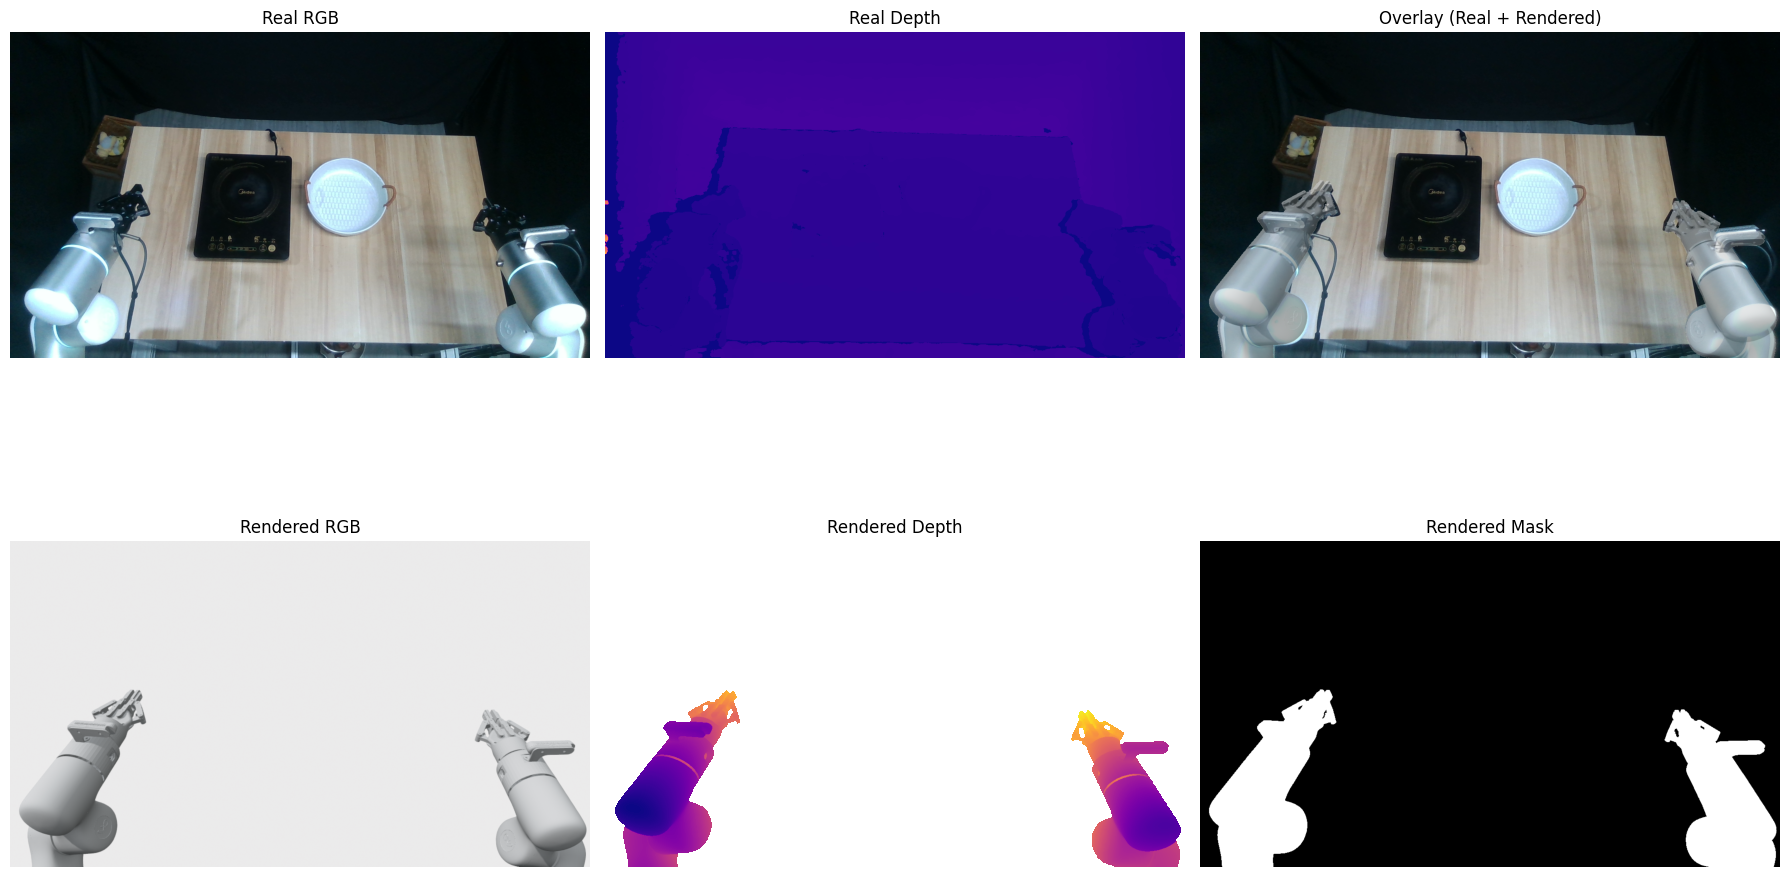


结果已保存到: /data/haoxiang/data/airexo2/task_0013/train/scene_0001/rendered_output
渲染图像形状: (720, 1280, 3)
深度范围: [0.706, inf] 米
掩码覆盖像素: 104283 / 921600


/tmp/ipykernel_259316/239272391.py:124: RuntimeWarning: invalid value encountered in cast
  cv2.imwrite(os.path.join(output_dir, "rendered_depth.png"), (rendered_depth * 1000).astype(np.uint16))


In [4]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from omegaconf import OmegaConf
from airexo.helpers.renderer import RobotRenderer
from airexo.calibration.calib_info import CalibrationInfo

# ========== 1. 读取关节数据 ==========
scene_path = "/data/haoxiang/data/airexo2/task_0013/train/scene_0001"
lowdim_path = os.path.join(scene_path, "lowdim")

with h5py.File(f"{lowdim_path}/robot_left.h5", 'r') as f:
    left_joint = f['joint_pos'][0]

with h5py.File(f"{lowdim_path}/robot_right.h5", 'r') as f:
    right_joint = f['joint_pos'][0]

with h5py.File(f"{lowdim_path}/gripper_left.h5", 'r') as f:
    left_gripper = f['width'][0] if 'width' in f else 0.05

with h5py.File(f"{lowdim_path}/gripper_right.h5", 'r') as f:
    right_gripper = f['width'][0] if 'width' in f else 0.05

left_joint = np.concatenate([left_joint, [left_gripper]])
right_joint = np.concatenate([right_joint, [right_gripper]])

# ========== 2. 加载标定数据 ==========
calib_path = "/data/haoxiang/data/airexo2/task_0013/calib"
calib_info = CalibrationInfo(
    calib_path=calib_path,
    calib_timestamp=1737548651048
)

camera_serial = list(calib_info.camera_serials_global)[0]
print(f"Using camera: {camera_serial}")

cam_to_base = calib_info.get_camera_to_base(camera_serial)
intrinsic = calib_info.get_intrinsic(camera_serial)

# ========== 3. 加载配置 ==========
left_cfg = OmegaConf.load("airexo/configs/joint/left/robot.yaml")
right_cfg = OmegaConf.load("airexo/configs/joint/right/robot.yaml")

# ========== 4. 初始化 Renderer ==========
renderer = RobotRenderer(
    left_joint_cfgs=left_cfg,
    right_joint_cfgs=right_cfg,
    cam_to_base=cam_to_base,
    intrinsic=intrinsic,
    urdf_file="airexo/urdf_models/robot/robot_inhand.urdf",
    width=1280,
    height=720,
    near_plane=0.01,
    far_plane=100.0
)

# ========== 5. 更新关节并渲染 ==========
renderer.update_joints(left_joint, right_joint)

# 渲染图像、深度和掩码
rendered_rgb = renderer.render_image()
rendered_depth = renderer.render_depth()
rendered_mask = renderer.render_mask(depth=rendered_depth)

# ========== 6. 读取真实相机图像 ==========
cam_path = os.path.join(scene_path, f"cam_{camera_serial}")
rgb_path = os.path.join(cam_path, "color", "1737546126606.png")
depth_path = os.path.join(cam_path, "depth", "1737546126606.png")

real_rgb = cv2.imread(rgb_path)
real_rgb = cv2.cvtColor(real_rgb, cv2.COLOR_BGR2RGB)
real_depth = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED).astype(np.float32) / 1000.0

# ========== 7. 叠加显示（机械臂覆盖在真实图像上） ==========
alpha = 0.6  # 透明度
overlay_rgb = real_rgb.copy()

# 只在有机械臂的地方叠加
mask_bool = rendered_mask > 0
overlay_rgb[mask_bool] = (
    rendered_rgb[mask_bool] * alpha + 
    real_rgb[mask_bool] * (1 - alpha)
).astype(np.uint8)

# ========== 8. 可视化 ==========
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 第一行：真实图像
axes[0, 0].imshow(real_rgb)
axes[0, 0].set_title("Real RGB")
axes[0, 0].axis('off')

axes[0, 1].imshow(real_depth, cmap='plasma')
axes[0, 1].set_title("Real Depth")
axes[0, 1].axis('off')

axes[0, 2].imshow(overlay_rgb)
axes[0, 2].set_title("Overlay (Real + Rendered)")
axes[0, 2].axis('off')

# 第二行：渲染结果
axes[1, 0].imshow(rendered_rgb)
axes[1, 0].set_title("Rendered RGB")
axes[1, 0].axis('off')

axes[1, 1].imshow(rendered_depth, cmap='plasma')
axes[1, 1].set_title("Rendered Depth")
axes[1, 1].axis('off')

axes[1, 2].imshow(rendered_mask, cmap='gray')
axes[1, 2].set_title("Rendered Mask")
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

# ========== 9. 保存结果 ==========
output_dir = os.path.join(scene_path, "rendered_output")
os.makedirs(output_dir, exist_ok=True)

cv2.imwrite(os.path.join(output_dir, "rendered_rgb.png"), cv2.cvtColor(rendered_rgb, cv2.COLOR_RGB2BGR))
cv2.imwrite(os.path.join(output_dir, "rendered_depth.png"), (rendered_depth * 1000).astype(np.uint16))
cv2.imwrite(os.path.join(output_dir, "rendered_mask.png"), rendered_mask)
cv2.imwrite(os.path.join(output_dir, "overlay.png"), cv2.cvtColor(overlay_rgb, cv2.COLOR_RGB2BGR))

print(f"\n结果已保存到: {output_dir}")
print(f"渲染图像形状: {rendered_rgb.shape}")
print(f"深度范围: [{rendered_depth.min():.3f}, {rendered_depth.max():.3f}] 米")
print(f"掩码覆盖像素: {(rendered_mask > 0).sum()} / {rendered_mask.size}")